### Import Libraries

In [3]:
import numpy as np
import xarray as xr
import h5py 
import random

from sklearn import tree
import graphviz

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


### Define Plotting Methods

In [4]:
import sys
sys.path.append('../tools')

import training
import plotting
import io

import importlib

importlib.reload(training)
importlib.reload(plotting)
importlib.reload(io)


<module 'plotting' from '../tools/plotting.py'>

#### Define Functions for data extraction

##### Read trainig-data

In [7]:
data_directory = "../data/"
filename_labels = "nwcsaf_msevi-nawdex-20160925.nc"
filename_data = "msevi-nawdex-20160925.nc"
filename_mask = "region_masks_for_msevi_nawdex.h5"

sat_data = xr.open_dataset(data_directory+filename_data)
label_data = xr.open_dataset(data_directory+filename_labels)
mask_data = h5py.File(data_directory+filename_mask, 'r')

lons = sat_data['lon']
lats = sat_data['lat']




##### Convert mask to xr-Dataset

In [8]:
dims = ['rows', 'cols']
coords = {'lat': sat_data.coords['lat'], 'lon':sat_data.coords['lon']}

mask_ds = xr.Dataset()
for key in mask_data.keys():
	if key == "_source":
		continue
	m = xr.DataArray([row for row in mask_data[key]], dims = dims, coords = coords, name = key + "_mask")
	mask_ds[key + "_mask"] = m

    

##### create masked indices and discard those pointing to 'nan's

In [9]:
clean_indeces = np.where(mask_ds["mediterranean_mask"])
for i in range(24):
    a,b = extractLearningData(sat_data, label_data, clean_indeces, hour = i)
    #print(b.shape)
    _, _, clean_indeces = io.clean_data(a,b,clean_indeces)



1 positions deleted for including nan-values.
2 positions deleted for including nan-values.
1 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
0 positions deleted for including nan-values.
5 positions deleted for including nan-values.
1 positions deleted for including 

##### Extract trainig samples and corresponding labels

In [10]:

n = 1000
# number of points from the mapped dataset choose for learning 
#(each point is sampled 24x, once for every timeframe)

# create a selection of 'n' index-pairs
selection = np.array(random.sample(list(zip(clean_indeces[0],clean_indeces[1])),n))
s = selection.shape
selection = selection.flatten().reshape(s[1],s[0],order = 'F')

training_data = np.empty([0,8])
training_labels = np.array([])
# get values for each selected point for each hour
for i in range(24):
    a,b = extractLearningData(sat_data, label_data,selection, hour = i)
    training_data = np.append(training_data, a, axis=0)
    training_labels = np.append(training_labels, b, axis=0)

training_data = np.array(training_data)
#print(training_data.shape)
#print(training_labels.shape)
    

##### Train classifier with selected data

In [11]:
cl = tree.DecisionTreeClassifier()
cl.fit(training_data, training_labels)

DecisionTreeClassifier()

##### Read test data

In [12]:
filename_testlabels = "nwcsaf_msevi-nawdex-20160920.nc"
filename_testdata = "msevi-nawdex-20160920.nc"
hour = 12

raw_test_data = xr.open_dataset(data_directory+filename_testdata)
raw_test_label = xr.open_dataset(data_directory+filename_testlabels)


test_indices = np.where(mask_ds["mediterranean_mask"])
test_data, test_labels = extractLearningData(raw_test_data, raw_test_label, test_indices, hour)
test_data, test_labels, test_indices = cleanData(test_data, test_labels, test_indices)


0 positions deleted for including nan-values.


#### Evaluate model

In [13]:
pred_labels = cl.predict(test_data)

correct = np.sum(pred_labels == test_labels)
total = len(pred_labels)
print("Correctly identified %i out of %i labels! \nPositve rate is: %f" % (correct, total, correct/total))

Correctly identified 124822 out of 171396 labels! 
Positve rate is: 0.728267


#### Return data-vectors into the form of the original dataset (xarray)

In [14]:
def imbedData(data, indices, shape, dims, coords, name):
    new_data = np.empty(shape)
    new_data[:] = np.nan
    
    new_data[indices[0],indices[1]] = data
    new_data = xr.DataArray(new_data, dims = dims, coords = coords, name = name)
    return new_data
    

In [15]:
dims = ['rows', 'cols']
coords = {'lat': sat_data.coords['lat'], 'lon':sat_data.coords['lon']}

pred_labels_imb = imbedData(pred_labels, test_indices, lons.shape, dims, coords, "predicted_labels")
test_labels_imb = imbedData(test_labels, test_indices, lons.shape, dims, coords, "real_labels")

lats_masked = lats.where(mask_ds["mediterranean_mask"])
lons_masked = lons.where(mask_ds["mediterranean_mask"])


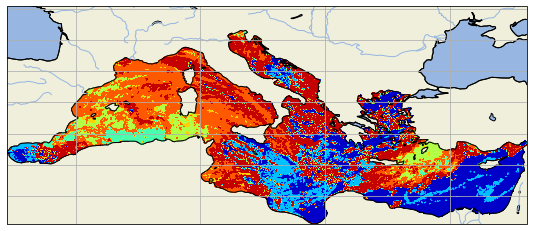

In [17]:
plotting.plot_data(pred_labels_imb, lons_masked, lats_masked)

In [ ]:
plotting.plot_data(test_labels_imb, lons_masked, lats_masked)

### test stuff and such

In [ ]:
a = np.array([[1,2,3],[1,4,10]])
a = training.create_difference_vectors(a)
print(a)

In [ ]:

print(training_data.shape)
new_training_data = training.create_difference_vectors(training_data,keep_original_values = True)
print(new_training_data.shape)

new_training_data = training.create_difference_vectors(training_data,keep_original_values = False)
print(new_training_data.shape)

In [ ]:
a,b = extractLearningData(sat_data, label_data, mapped_indeces)
print(a.shape)
print(b.shape)
print(mapped_indeces[0].shape)

clean_data, clean_labels,clean_indeces = cleanData(a,b,mapped_indeces)
print(clean_labels.shape)

In [ ]:
a = np.array([[1,2,3,4,5],[9,8,9,7,9], [11,11,11,11,11]])
a.flatten().reshape((5,3), order='F')